# Práctica 2.2: 

### Segmentación 

*Alejandro Alonso Membrilla*

A modo de anotación, el orden del código presente en este cuaderno no se corresponde directamente con el seguido en la memoria presentada. La aplicación de los ditintos algoritmos se ha separado, haciendo primero ambos casos con el K-medias y luego ambos con el clustering aglomerativo. Las gráficas de cajas usadas en el análisis de resultados de cada caso se han obtenido al final, en el apartado Resultados.

También se recomienda eliminar la salida de los scatter_3d una vez se han observado los resultados porque se generan muchos y, en total, llegan a consumir varios GB de RAM. 

In [61]:
#Comentar las siguientes líneas para ejecutar el siguiente script fuera de GoogleColab
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
#cd '/content/gdrive/My Drive/Inteligencia de Negocio/Prácticas/P2'

/content/gdrive/My Drive/Inteligencia de Negocio/Prácticas/P2


In [63]:
def calcular_centroides(df, labels):
  df_clustered = df.copy()
  df_clustered['cluster'] = labels
  return df_clustered.groupby('cluster').mean().values

In [64]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from collections import Counter
from pract2_utils import *
raw_data=pd.read_csv("accidentes_2013.csv",na_values=["?", "N"])

In [65]:
atributos = ['TOT_VICTIMAS', 'TOT_MUERTOS', 'TOT_HERIDOS_GRAVES', 'TOT_HERIDOS_LEVES', 'TOT_VEHICULOS_IMPLICADOS']

Voy a aplicar clustering. Para ello voy a utilizar únicamente los valores numéricos.

In [ ]:
raw_data.head()

,MES,HORA,DIASEMANA,PROVINCIA,COMUNIDAD_AUTONOMA,ISLA,TOT_VICTIMAS,TOT_VICTIMAS30D,TOT_MUERTOS,TOT_MUERTOS30D,TOT_HERIDOS_GRAVES,TOT_HERIDOS_GRAVES30D,TOT_HERIDOS_LEVES,TOT_HERIDOS_LEVES30D,TOT_VEHICULOS_IMPLICADOS,ZONA,ZONA_AGRUPADA,RED_CARRETERA,TIPO_VIA,TRAZADO_NO_INTERSEC,TIPO_INTERSEC,ACOND_CALZADA,PRIORIDAD,SUPERFICIE_CALZADA,LUMINOSIDAD,FACTORES_ATMOSFERICOS,VISIBILIDAD_RESTRINGIDA,OTRA_CIRCUNSTANCIA,ACERAS,TIPO_ACCIDENTE,DENSIDAD_CIRCULACION,MEDIDAS_ESPECIALES
0,8,14.0,3,Bizkaia,País Vasco,NO_ES_ISLA,3,3,0,0.054104,3,2.945896,0,0.0,2,CARRETERA,VÍAS INTERURBANAS,"TITULARIDAD PROVINCIAL (DIPUTACIÓN, CABILDO O ...",OTRO TIPO,CURVA SUAVE,NO_ES_INTERSECCION,NaN,NINGUNA (SOLO NORMA),MOJADA,PLENO DÍA,LLUVIA FUERTE,FACTORES ATMOSFÉRICOS,OTRA,NO HAY ACERA,Colisión de vehículos en marcha (Frontal),FLUIDA,NINGUNA MEDIDA
1,6,18.0,6,Bizkaia,País Vasco,NO_ES_ISLA,1,1,0,0.000000,0,0.000000,1,1.0,3,CARRETERA,VÍAS INTERURBANAS,OTRAS TITULARIDADES,OTRO TIPO,ES_INTERSECCION,ENLACE DE SALIDA,NADA ESPECIAL,SEMÁFORO,MOJADA,PLENO DÍA,LLOVIZNANDO,OTRA_CAUSA,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Alcance),DENSA,NINGUNA MEDIDA
2,11,17.0,2,Tarragona,Cataluña,NO_ES_ISLA,2,2,0,0.000000,0,0.000000,2,2.0,2,CARRETERA,VÍAS INTERURBANAS,TITULARIDAD MUNICIPAL,VÍA CONVENCIONAL,ES_INTERSECCION,EN T Ó Y,NaN,SEÑAL DE STOP,SECA Y LIMPIA,PLENO DÍA,BUEN TIEMPO,NaN,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Frontolateral),NaN,NaN
3,1,9.0,3,Lleida,Cataluña,NO_ES_ISLA,2,2,0,0.000000,0,0.000000,2,2.0,3,VARIANTE,VÍAS INTERURBANAS,TITULARIDAD ESTATAL,VÍA CONVENCIONAL,RECTA,NO_ES_INTERSECCION,NaN,NaN,MOJADA,PLENO DÍA,LLOVIZNANDO,NaN,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Múltiple o en...,NaN,NINGUNA MEDIDA
4,11,22.0,7,Barcelona,Cataluña,NO_ES_ISLA,2,2,0,0.000000,0,0.000000,2,2.0,2,CARRETERA,VÍAS INTERURBANAS,TITULARIDAD MUNICIPAL,VÍA CONVENCIONAL,RECTA,NO_ES_INTERSECCION,NaN,NaN,MOJADA,NOCHE: ILUMINACIÓN SUFICIENTE,LLUVIA FUERTE,NaN,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Frontolateral),NaN,NaN


In [ ]:
raw_data["ZONA_AGRUPADA"].value_counts()

VÍAS URBANAS         52222
VÍAS INTERURBANAS    37297
Name: ZONA_AGRUPADA, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



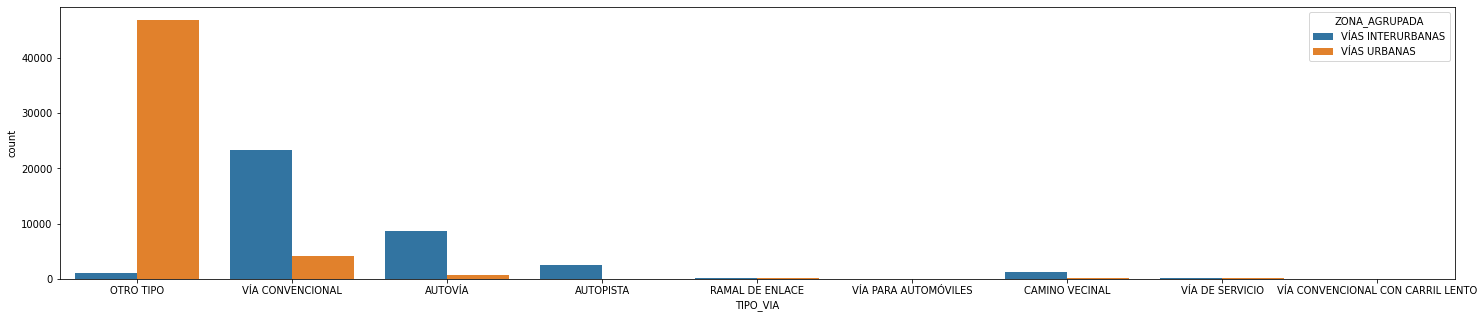

In [ ]:
fig = plt.figure(figsize=(25,5))
sns.countplot( "TIPO_VIA", data=raw_data, hue="ZONA_AGRUPADA", ax=plt.axes() )
#fig.savefig("tipo_via_por_zona")

In [ ]:
raw_data["TIPO_VIA"].loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"].value_counts()

VÍA CONVENCIONAL                     23327
AUTOVÍA                               8712
AUTOPISTA                             2456
CAMINO VECINAL                        1329
OTRO TIPO                             1050
RAMAL DE ENLACE                        222
VÍA DE SERVICIO                         94
VÍA PARA AUTOMÓVILES                    68
VÍA CONVENCIONAL CON CARRIL LENTO       39
Name: TIPO_VIA, dtype: int64

In [72]:
comp_zonas = raw_data.groupby('ZONA_AGRUPADA')[atributos].sum()

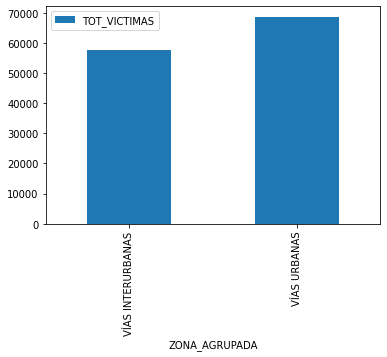

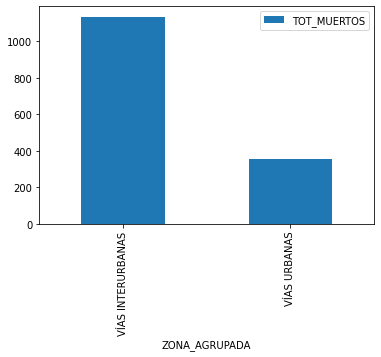

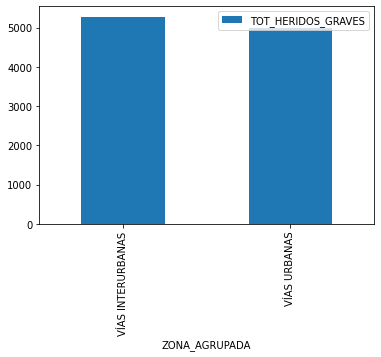

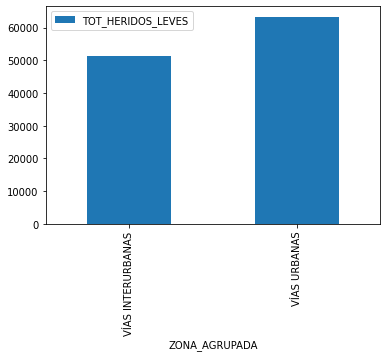

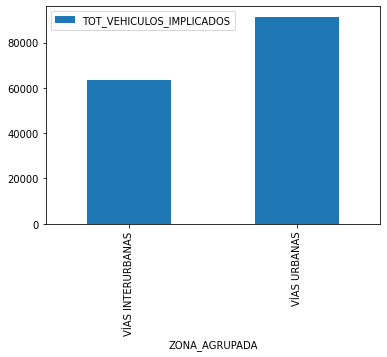

In [80]:
for at in atributos:
  comp_zonas.plot.bar(y=at)

Vamos a aplicar una segmentación sobre los accidentes que se produjeron en vías urbanas, y luego en vías interurbanas. Primero nos quedamos con los atributos numéricos.

## Caso 1: Accidentes en Vías Urbanas (K-means)

### Visualización con Análisis de Componentes Principales

In [ ]:
raw_data_vias_urbanas = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS URBANAS"]
data_vias_urbanas = to_matrix(raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS URBANAS"], atributos)
data_vias_urbanas_norm = norm(data_vias_urbanas)
print(data_vias_urbanas)
print(data_vias_urbanas_norm)

[[3 0 0 3 2]
 [1 0 0 1 2]
 [1 0 0 1 2]
 ...
 [1 0 1 0 2]
 [2 0 0 2 2]
 [2 0 0 2 3]]
[[0.15384615 0.         0.         0.25       0.07692308]
 [0.         0.         0.         0.08333333 0.07692308]
 [0.         0.         0.         0.08333333 0.07692308]
 ...
 [0.         0.         0.1        0.         0.07692308]
 [0.07692308 0.         0.         0.16666667 0.07692308]
 [0.07692308 0.         0.         0.16666667 0.15384615]]


In [ ]:
pca = PCA(n_components=3)
pca.fit(data_vias_urbanas_norm)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print(pca.explained_variance_ratio_)

[0.59897561 0.17208922 0.13380126]


Las 3 componentes principales explican un 90% de la varianza (para visualizarlas, necesitaremos un gráfico en 3D).

In [ ]:
data_vias_urbanas_red = pca.transform(data_vias_urbanas_norm)
print(data_vias_urbanas_red)

[[ 0.19756709 -0.01952217  0.00132783]
 [-0.02391575  0.02581549 -0.00212639]
 [-0.02391575  0.02581549 -0.00212639]
 ...
 [-0.09506687  0.02863723  0.01624269]
 [ 0.08682567  0.00314666 -0.00039928]
 [ 0.10133339  0.07718064  0.01367194]]


In [ ]:
fig = px.scatter_3d(x=data_vias_urbanas_red[:,0], y=data_vias_urbanas_red[:,1], z=data_vias_urbanas_red[:,2], title="Plot Vías Urbanas (ACP)")
fig.show()

### Aplico el k-means (análisis del valor de k)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
labels = {}
centroids = {}
for k in [2,3,4,5]:
  results = KMeans(n_clusters=k, random_state=1, n_init=100).fit(data_vias_urbanas_norm)
  #labels.append(results.labels_)
  labels[k] = results.labels_
  centroids[k] = results.cluster_centers_
  df_k_clusters = pd.DataFrame(data_vias_urbanas_red)
  df_k_clusters["Label"] = [ "{}".format(l) for l in results.labels_ ]
  fig = px.scatter_3d(df_k_clusters, x=0, y=1, z=2, title="K = {}".format(k), color="Label")
  fig.show()

In [ ]:
#Contamos los elementos de cada cluster
from collections import Counter

for k in [2,3,4,5]:
  print(Counter(labels[k]))

Counter({0: 41844, 1: 10378})
Counter({0: 41519, 1: 10355, 2: 348})
Counter({1: 41492, 0: 9198, 3: 1185, 2: 347})
Counter({1: 25963, 0: 15558, 3: 9169, 2: 1185, 4: 347})


### Obtengo las medidas

In [55]:
df_medidas = pd.DataFrame(columns=["K", "Silhouette", "Calinsky-Harabasz"])
for k in [2,3,4,5]:
  silhouette, calinski = measures_silhoutte_calinski(data_vias_urbanas_norm, labels[k])
  print("K = {}".format(k))
  print("silhouette: {:3f}".format(silhouette))
  print("calinsky: {:3f}".format(calinski))
  df_medidas = df_medidas.append(pd.DataFrame( data=[[k, silhouette, calinski]], columns=["K", "Silhouette", "Calinsky-Harabasz"] ) )

df_medidas

K = 2
silhouette: 0.603827
calinsky: 31943.592964
K = 3
silhouette: 0.618618
calinsky: 27219.744201
K = 4
silhouette: 0.600360
calinsky: 30629.996137
K = 5
silhouette: 0.673118
calinsky: 36913.874156


,K,Silhouette,Calinsky-Harabasz
0,2,0.603827,31943.592964
0,3,0.618618,27219.744201
0,4,0.600360,30629.996137
0,5,0.673118,36913.874156


In [59]:
df_medidas.to_csv("medidas_urbanas_kmeans.csv", index=False)

### Visualizo los centroides

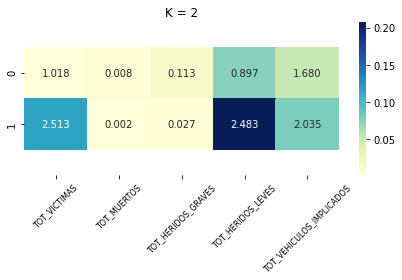

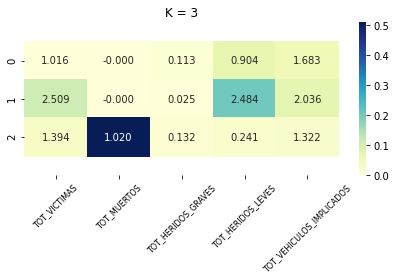

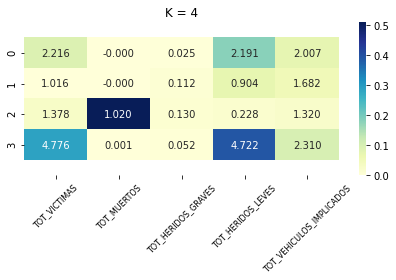

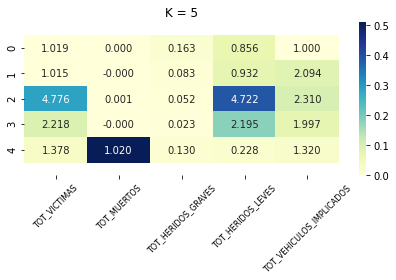

In [ ]:
for k in [2,3,4,5]:
  heatmap = visualize_centroids(centroids[k], data_vias_urbanas, atributos)   #Devuelve un AvesSubplot
  #heatmap.figure.savefig("heatmap_urbanas_kmeans_k{}.png".format(k))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distribu

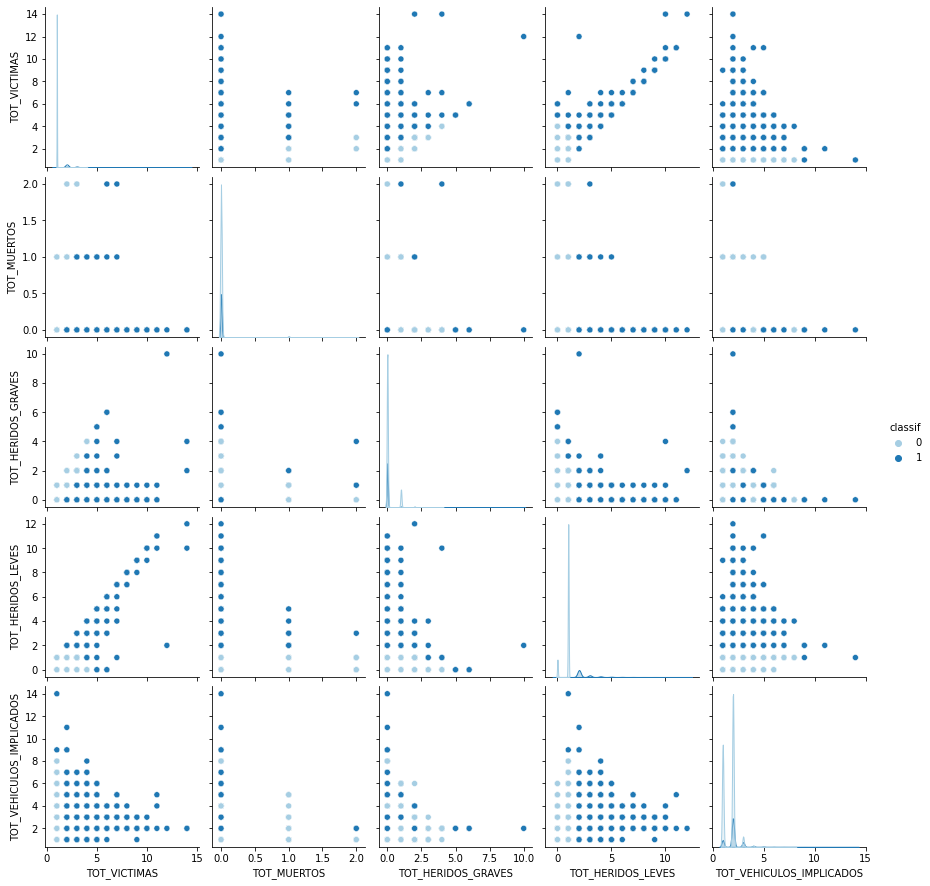

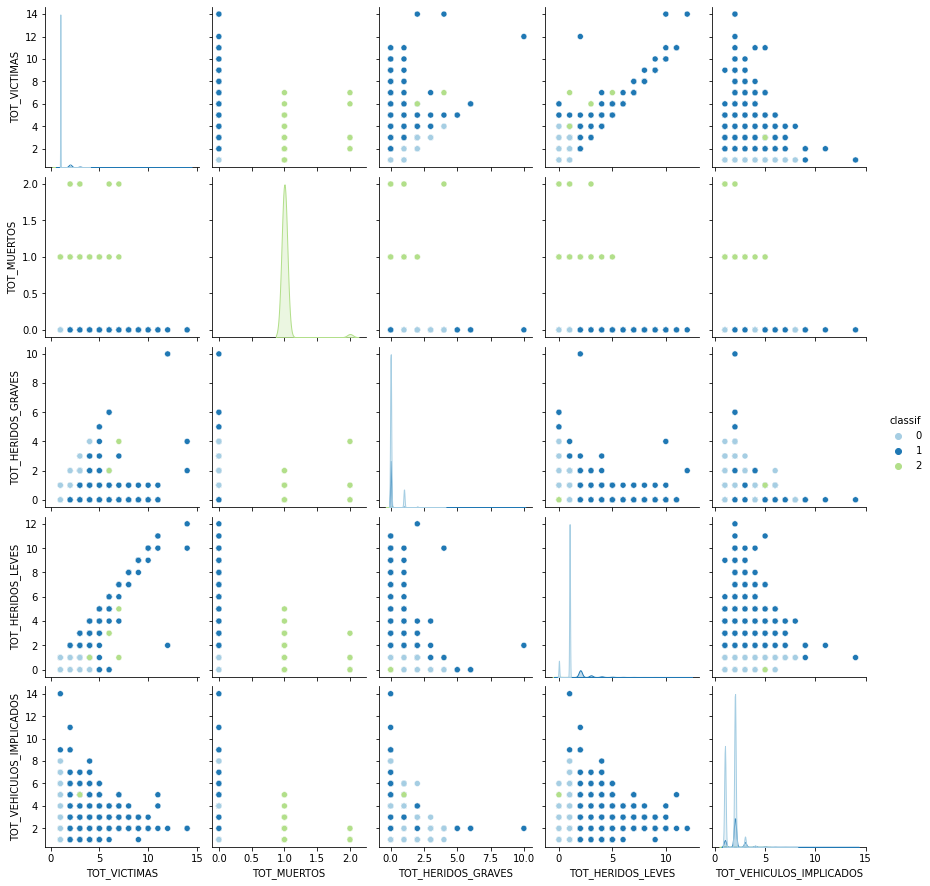

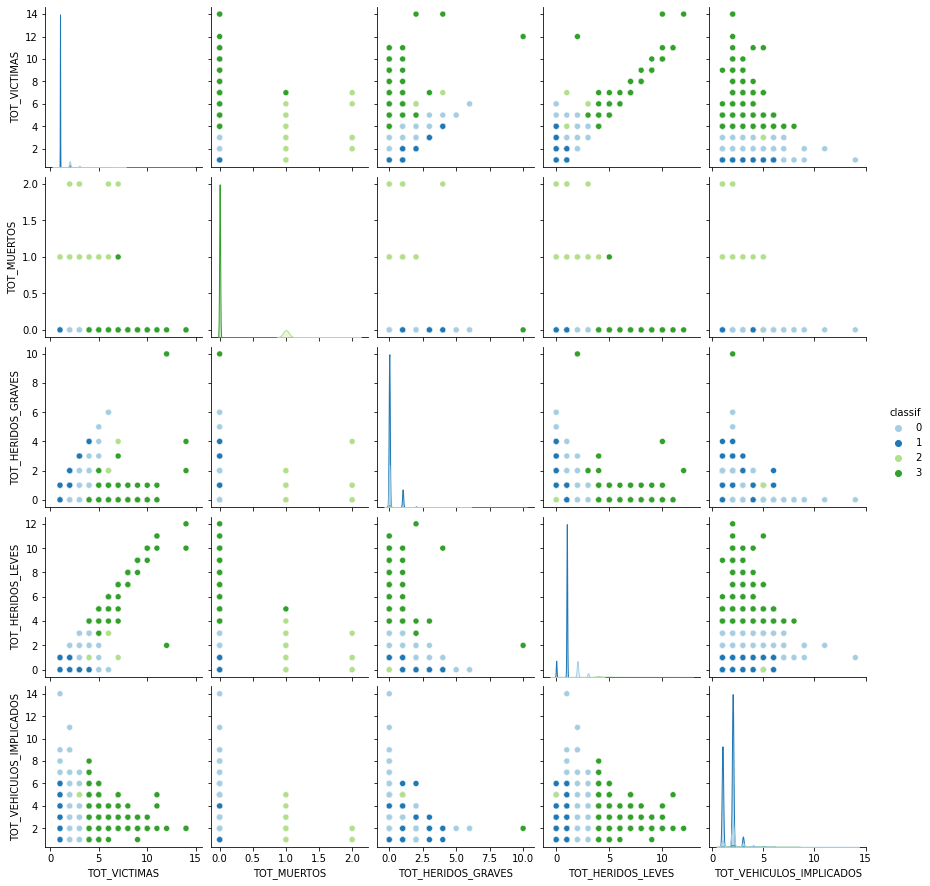

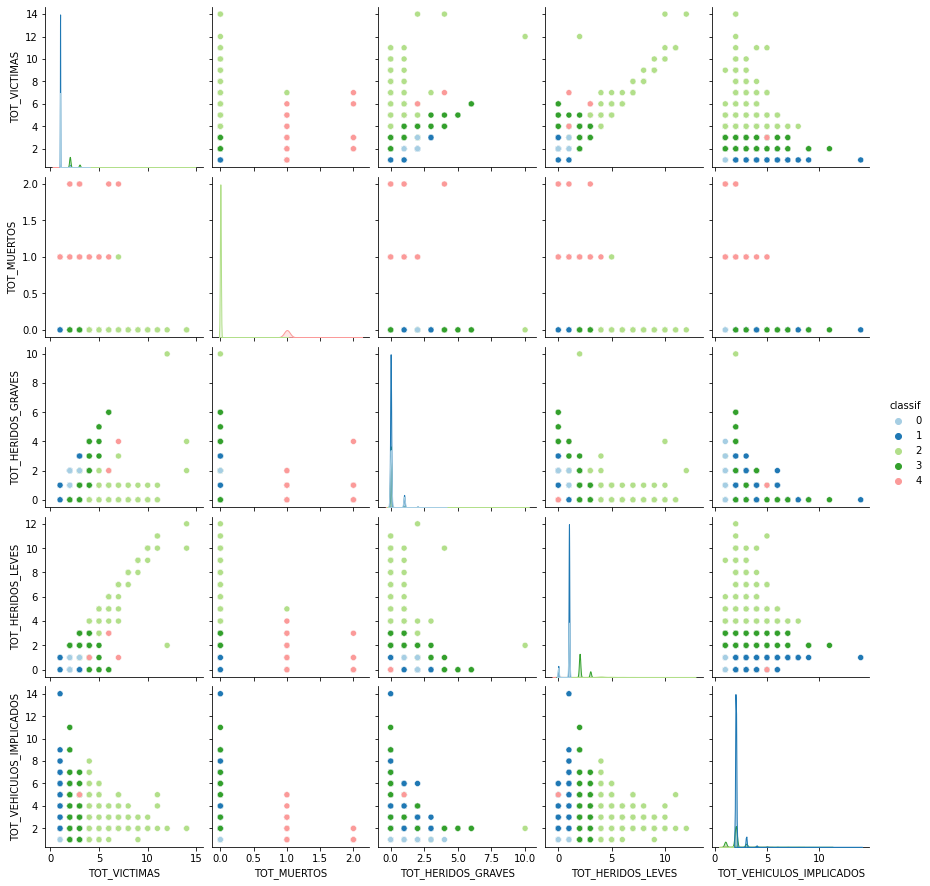

In [ ]:
df = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS URBANAS"]  #Pairplot necesita un DataFrame y hasta ahora yo almacenaba los datos en ndarrays
for k in [2,3,4,5]:
  pplot = pairplot(df, atributos, labels[k])
  #pplot.savefig("pairplot_urbanas_kmeans_k{}.png".format(k))

## Caso 2: Accidentes en Vías Interurbanas (K-means)

### Visualización con Análisis de Componentes Principales

In [97]:
raw_data_vias_interurbanas = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"]
data_vias_interurbanas = to_matrix(raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"], atributos)
data_vias_interurbanas_norm = norm(data_vias_interurbanas)
print(data_vias_interurbanas)
print(data_vias_interurbanas_norm)

[[3 0 3 0 2]
 [1 0 0 1 3]
 [2 0 0 2 2]
 ...
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 2]]
[[0.03921569 0.         0.33333333 0.         0.04444444]
 [0.         0.         0.         0.0212766  0.06666667]
 [0.01960784 0.         0.         0.04255319 0.04444444]
 ...
 [0.         0.         0.         0.0212766  0.02222222]
 [0.         0.         0.         0.0212766  0.02222222]
 [0.         0.         0.         0.0212766  0.04444444]]


In [98]:
pca = PCA(n_components=3)
pca.fit(data_vias_interurbanas_norm)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [99]:
print(pca.explained_variance_ratio_)

[0.54651161 0.24410747 0.12167346]


Las 3 componentes principales explican más del 90% de la varianza (para visualizarlas, necesitaremos un gráfico en 3D).

In [100]:
data_vias_interurbanas_red = pca.transform(data_vias_interurbanas)
print(data_vias_interurbanas_red)

[[ 3.17537619  2.59493318 -0.06735097]
 [-0.05990005  2.17337025 -0.02683741]
 [-0.10204765  3.24027316 -0.0125409 ]
 ...
 [-0.05754325  1.600672   -0.00624931]
 [-0.05754325  1.600672   -0.00624931]
 [-0.05872165  1.88702112 -0.01654336]]


In [ ]:
fig = px.scatter_3d(x=data_vias_interurbanas_red[:,0], y=data_vias_interurbanas_red[:,1], z=data_vias_interurbanas_red[:,2], 
                    title="Plot Vías Interurbanas (ACP)")
fig.show()

### Aplico el k-means (análisis del valor de k)

In [102]:
from sklearn.cluster import KMeans

In [ ]:
labels = {}
centroids = {}
for k in [2,3,4,5]:
  results = KMeans(n_clusters=k, random_state=1, n_init=100).fit(data_vias_interurbanas_norm)
  #labels.append(results.labels_)
  labels[k] = results.labels_
  centroids[k] = results.cluster_centers_
  df_k_clusters = pd.DataFrame(data_vias_interurbanas_red)
  df_k_clusters["Label"] = [ "{}".format(l) for l in results.labels_ ]
  fig = px.scatter_3d(df_k_clusters, x=0, y=1, z=2, title="K = {}".format(k), color="Label")
  fig.show()

In [104]:
#Contamos los elementos de cada cluster
from collections import Counter

for k in [2,3,4,5]:
  print(Counter(labels[k]))

Counter({1: 32734, 0: 4563})
Counter({1: 28906, 2: 4517, 0: 3874})
Counter({0: 28256, 1: 4339, 2: 3780, 3: 922})
Counter({1: 28204, 0: 3833, 2: 3780, 3: 906, 4: 574})


### Obtengo las medidas

In [105]:
df_medidas = pd.DataFrame(columns=["K", "Silhouette", "Calinsky-Harabasz"])
for k in [2,3,4,5]:
  silhouette, calinski = measures_silhoutte_calinski(data_vias_interurbanas_norm, labels[k])
  print("K = {}".format(k))
  print("silhouette: {:3f}".format(silhouette))
  print("calinsky: {:3f}".format(calinski))
  df_medidas = df_medidas.append(pd.DataFrame( data=[[k, silhouette, calinski]], columns=["K", "Silhouette", "Calinsky-Harabasz"] ) )

df_medidas

K = 2
silhouette: 0.717656
calinsky: 31386.168580
K = 3
silhouette: 0.616415
calinsky: 25945.890799
K = 4
silhouette: 0.651125
calinsky: 24356.945917
K = 5
silhouette: 0.662340
calinsky: 25462.961948


,K,Silhouette,Calinsky-Harabasz
0,2,0.717656,31386.168580
0,3,0.616415,25945.890799
0,4,0.651125,24356.945917
0,5,0.662340,25462.961948


In [106]:
df_medidas.to_csv("medidas_interurbanas_kmeans.csv", index=False)

### Visualizo los centroides

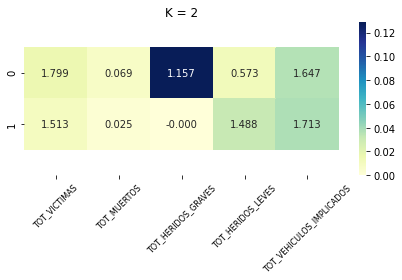

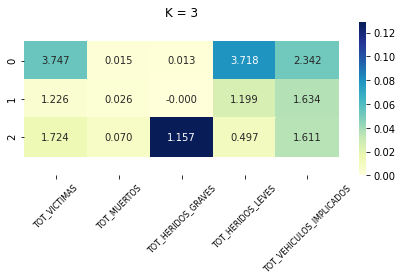

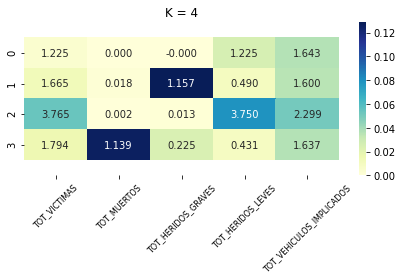

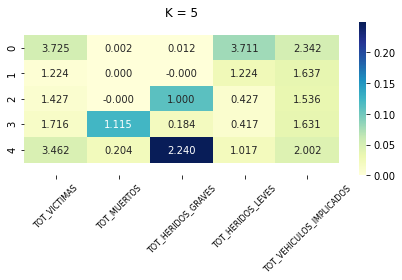

In [ ]:
for k in [2,3,4,5]:
  heatmap = visualize_centroids(centroids[k], data_vias_interurbanas, atributos)   #Devuelve un AvesSubplot
  #heatmap.figure.savefig("heatmap_interurbanas_kmeans_k{}.png".format(k))

In [ ]:
df = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"]  #Pairplot necesita un DataFrame y hasta ahora yo almacenaba los datos en ndarrays
for k in [2,3,4,5]:
  pplot = pairplot(df, atributos, labels[k])
  #pplot.savefig("pairplot_interurbanas_kmeans_k{}.png".format(k))

## Caso 1: Accidentes en Vías Urbanas (Clustering jerárquico)

### Visualización con Análisis de Componentes Principales

In [81]:
raw_data_vias_urbanas = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS URBANAS"]
data_vias_urbanas = to_matrix(raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS URBANAS"], atributos)
data_vias_urbanas_norm = norm(data_vias_urbanas)
print(data_vias_urbanas)
print(data_vias_urbanas_norm)

[[3 0 0 3 2]
 [1 0 0 1 2]
 [1 0 0 1 2]
 ...
 [1 0 1 0 2]
 [2 0 0 2 2]
 [2 0 0 2 3]]
[[0.15384615 0.         0.         0.25       0.07692308]
 [0.         0.         0.         0.08333333 0.07692308]
 [0.         0.         0.         0.08333333 0.07692308]
 ...
 [0.         0.         0.1        0.         0.07692308]
 [0.07692308 0.         0.         0.16666667 0.07692308]
 [0.07692308 0.         0.         0.16666667 0.15384615]]


In [82]:
pca = PCA(n_components=3)
pca.fit(data_vias_urbanas_norm)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [83]:
print(pca.explained_variance_ratio_)

[0.59897561 0.17208922 0.13380126]


Las 3 componentes principales explican un 90% de la varianza (para visualizarlas, necesitaremos un gráfico en 3D).

In [84]:
data_vias_urbanas_red = pca.transform(data_vias_urbanas_norm)
print(data_vias_urbanas_red)

[[ 0.19756709 -0.01952217  0.00132783]
 [-0.02391575  0.02581549 -0.00212639]
 [-0.02391575  0.02581549 -0.00212639]
 ...
 [-0.09506687  0.02863723  0.01624269]
 [ 0.08682567  0.00314666 -0.00039928]
 [ 0.10133339  0.07718064  0.01367194]]


In [ ]:
fig = px.scatter_3d(x=data_vias_urbanas_red[:,0], y=data_vias_urbanas_red[:,1], z=data_vias_urbanas_red[:,2], title="Plot Vías Urbanas (ACP)")
fig.show()

### Aplico el clustering jerárquico

In [86]:
from sklearn.cluster import AgglomerativeClustering

In [87]:
results = AgglomerativeClustering(2, memory='clustcache').fit(data_vias_urbanas_norm)

In [ ]:
labels = {}
centroids = {}
for k in [2,3,4,5]:
  results = AgglomerativeClustering(k, memory='clustcache').fit(data_vias_urbanas_norm)
  labels[k] = results.labels_
  centroids[k] = calcular_centroides(norm(raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS URBANAS"][atributos]), results.labels_)
  df_k_clusters = pd.DataFrame(data_vias_urbanas_red)
  df_k_clusters["Label"] = [ "{}".format(l) for l in results.labels_ ]
  fig = px.scatter_3d(df_k_clusters, x=0, y=1, z=2, title="K = {}".format(k), color="Label")
  fig.show()

In [ ]:
#Contamos los elementos de cada cluster
from collections import Counter

for k in [2,3,4,5]:
  print(Counter(labels[k]))

### Obtengo las medidas

In [89]:
df_medidas = pd.DataFrame(columns=["K", "Silhouette", "Calinsky-Harabasz"])
for k in [2,3,4,5]:
  silhouette, calinski = measures_silhoutte_calinski(data_vias_urbanas_norm, labels[k])
  print("K = {}".format(k))
  print("silhouette: {:3f}".format(silhouette))
  print("calinsky: {:3f}".format(calinski))
  df_medidas = df_medidas.append(pd.DataFrame( data=[[k, silhouette, calinski]], columns=["K", "Silhouette", "Calinsky-Harabasz"] ) )

df_medidas

K = 2
silhouette: 0.596926
calinsky: 30731.912582
K = 3
silhouette: 0.616207
calinsky: 26413.635657
K = 4
silhouette: 0.598885
calinsky: 29276.181478
K = 5
silhouette: 0.652563
calinsky: 34523.777567


,K,Silhouette,Calinsky-Harabasz
0,2,0.596926,30731.912582
0,3,0.616207,26413.635657
0,4,0.598885,29276.181478
0,5,0.652563,34523.777567


In [90]:
df_medidas.to_csv("medidas_urbanas_aglom.csv", index=False)

### Visualizo los centroides

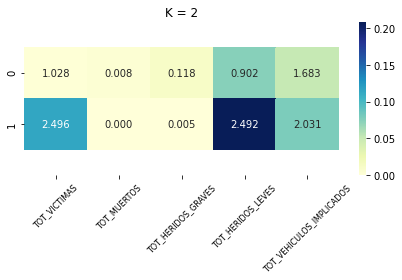

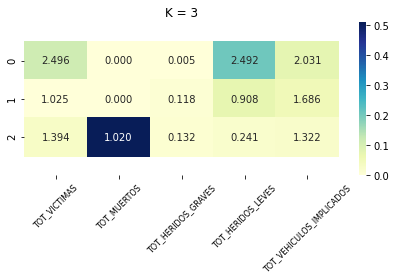

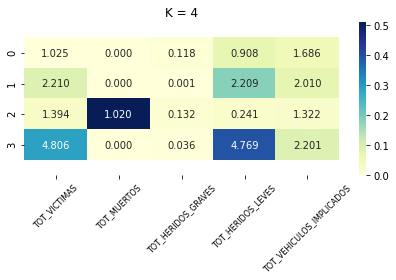

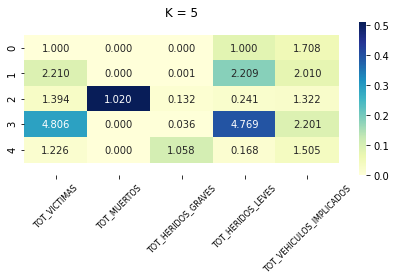

In [ ]:
for k in [2,3,4,5]:
  heatmap = visualize_centroids(centroids[k], data_vias_urbanas, atributos)   #Devuelve un AvesSubplot
  heatmap.figure.savefig("heatmap_urbanas_aglom_k{}.png".format(k))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distribu

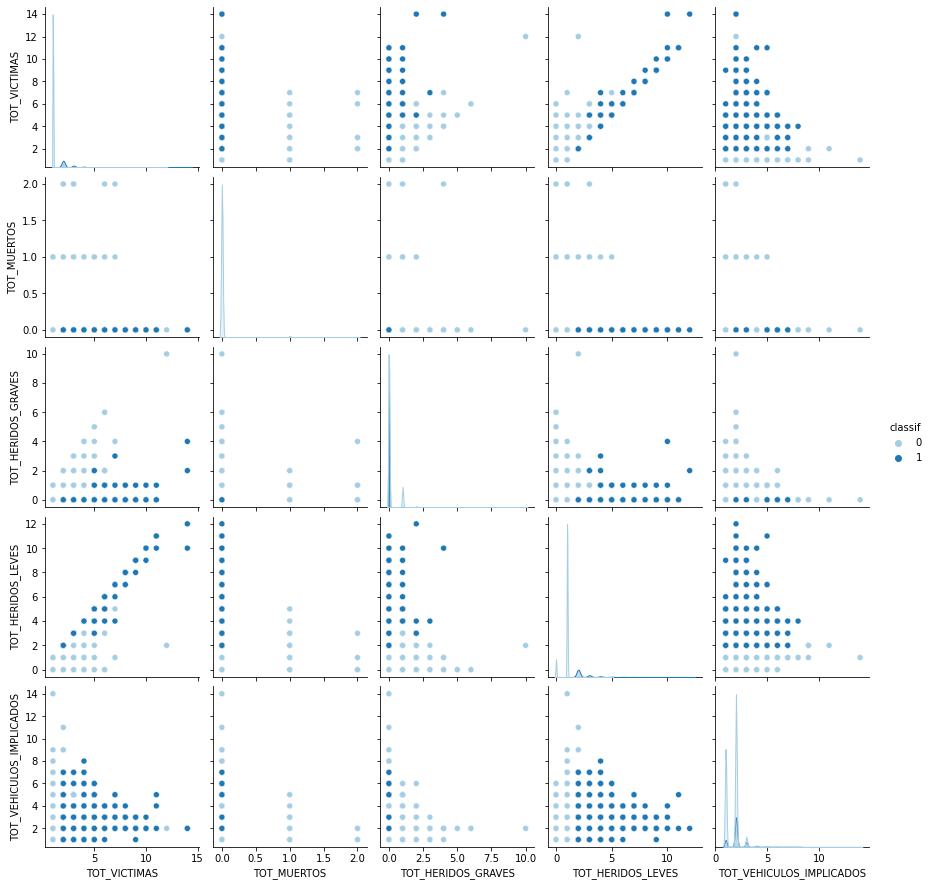

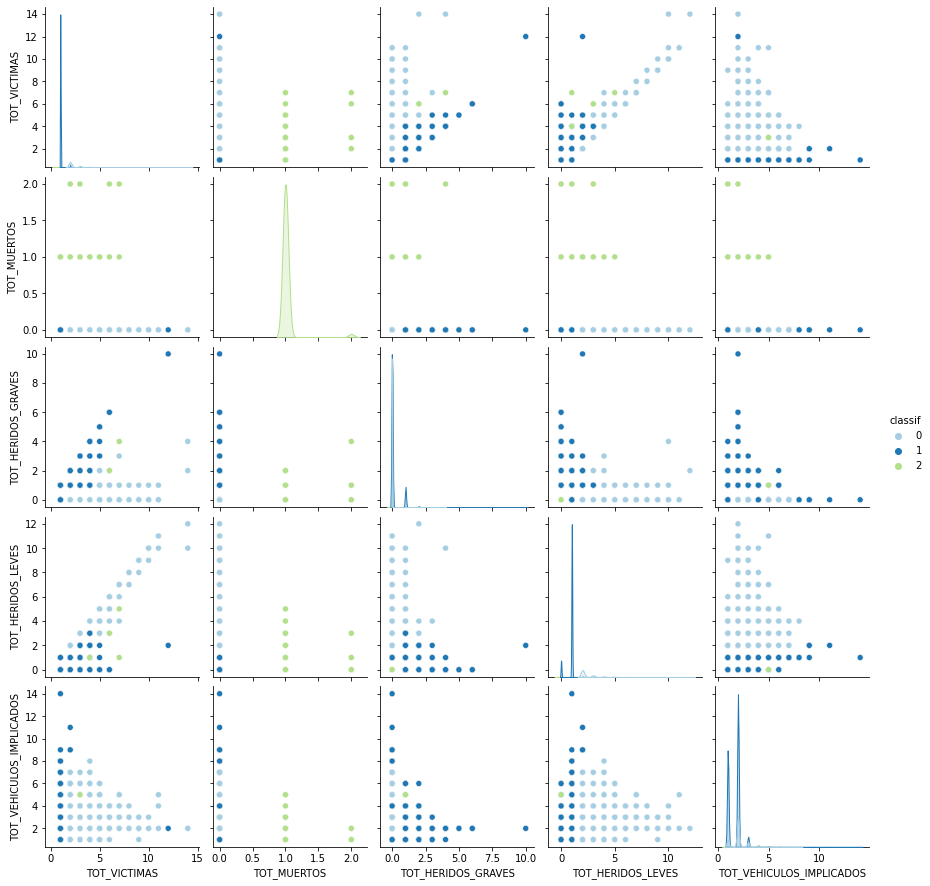

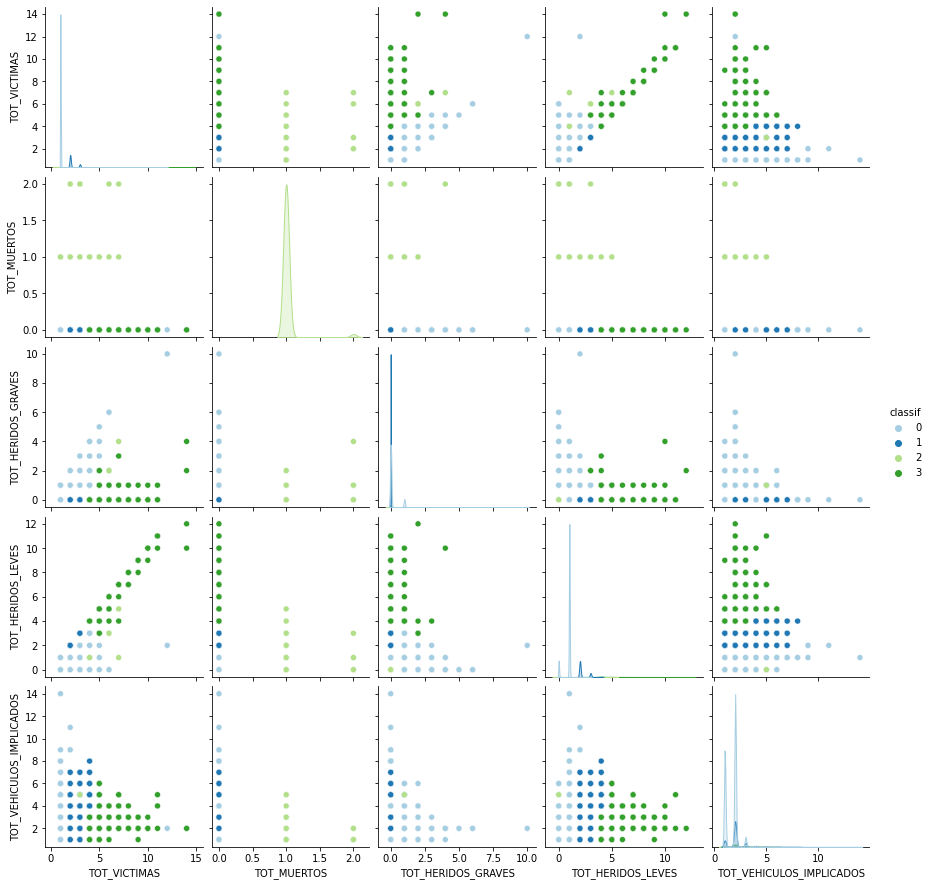

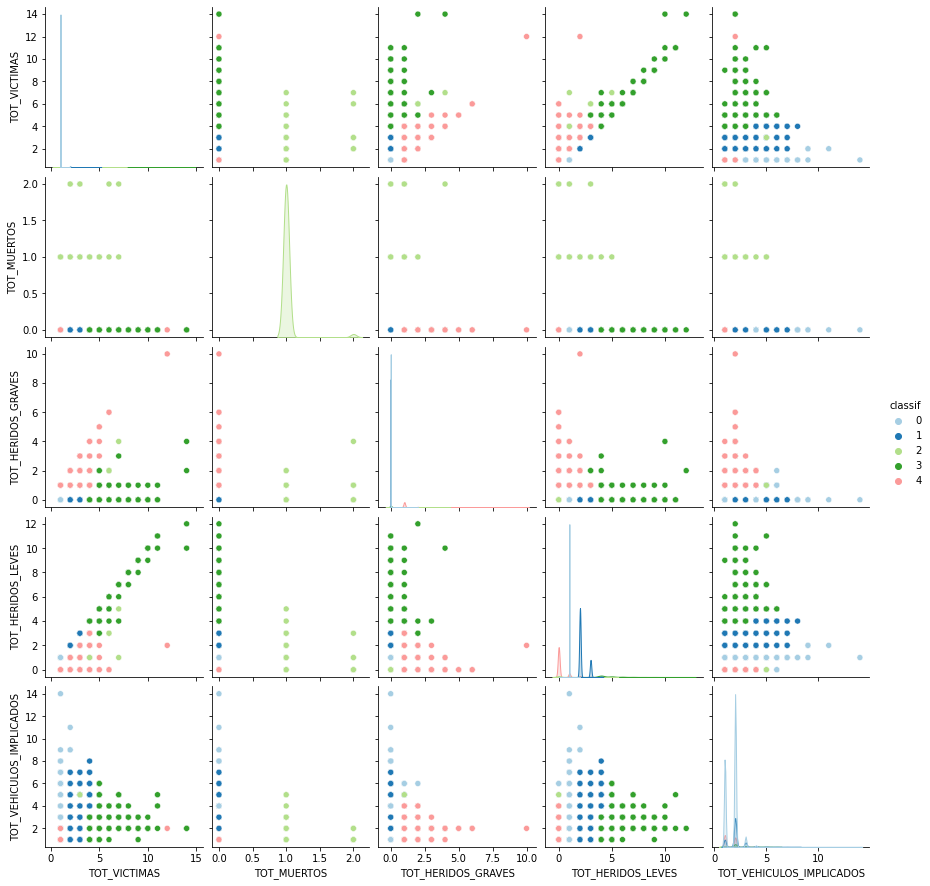

In [ ]:
df = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS URBANAS"]  #Pairplot necesita un DataFrame y hasta ahora yo almacenaba los datos en ndarrays
for k in [2,3,4,5]:
  pplot = pairplot(df, atributos, labels[k])
  pplot.savefig("pairplot_urbanas_aglom_k{}.png".format(k))

## Caso 2: Accidentes en Vías Interurbanas (Clustering jerárquico)

### Visualización con Análisis de Componentes Principales

In [107]:
raw_data_vias_interurbanas = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"]
data_vias_interurbanas = to_matrix(raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"], atributos)
data_vias_interurbanas_norm = norm(data_vias_interurbanas)
print(data_vias_interurbanas)
print(data_vias_interurbanas_norm)

[[3 0 3 0 2]
 [1 0 0 1 3]
 [2 0 0 2 2]
 ...
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 2]]
[[0.03921569 0.         0.33333333 0.         0.04444444]
 [0.         0.         0.         0.0212766  0.06666667]
 [0.01960784 0.         0.         0.04255319 0.04444444]
 ...
 [0.         0.         0.         0.0212766  0.02222222]
 [0.         0.         0.         0.0212766  0.02222222]
 [0.         0.         0.         0.0212766  0.04444444]]


In [108]:
pca = PCA(n_components=3)
pca.fit(data_vias_interurbanas_norm)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [109]:
print(pca.explained_variance_ratio_)

[0.54651161 0.24410747 0.12167346]


Las 3 componentes principales explican un 90% de la varianza (para visualizarlas, necesitaremos un gráfico en 3D).

In [110]:
data_vias_interurbanas_red = pca.transform(data_vias_interurbanas_norm)
print(data_vias_interurbanas_red)

[[ 0.31867866  0.01080158 -0.03019641]
 [-0.01568573 -0.004937   -0.00233701]
 [-0.01671051  0.01640284 -0.00216255]
 ...
 [-0.01563335 -0.01766363 -0.00187949]
 [-0.01563335 -0.01766363 -0.00187949]
 [-0.01565954 -0.01130032 -0.00210825]]


In [ ]:
fig = px.scatter_3d(x=data_vias_interurbanas_red[:,0], y=data_vias_interurbanas_red[:,1], z=data_vias_interurbanas_red[:,2], 
                    title="Plot Vías Interurbanas (ACP)")
fig.show()

### Aplico el clustering jerárquico

In [111]:
from sklearn.cluster import AgglomerativeClustering

In [112]:
results = AgglomerativeClustering(2, memory='clustcache').fit(data_vias_interurbanas_norm)

In [ ]:
labels = {}
centroids = {}
for k in [2,3,4,5]:
  results = AgglomerativeClustering(k, memory='clustcache').fit(data_vias_interurbanas_norm)
  labels[k] = results.labels_
  centroids[k] = calcular_centroides(norm(raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"][atributos]), results.labels_)
  df_k_clusters = pd.DataFrame(data_vias_interurbanas_red)
  df_k_clusters["Label"] = [ "{}".format(l) for l in results.labels_ ]
  fig = px.scatter_3d(df_k_clusters, x=0, y=1, z=2, title="K = {}".format(k), color="Label")
  fig.show()

In [123]:
#Contamos los elementos de cada cluster
from collections import Counter

for k in [2,3,4,5]:
  print(Counter(labels[k]))

Counter({0: 32970, 1: 4327})
Counter({0: 31996, 1: 4327, 2: 974})
Counter({3: 22218, 1: 9778, 0: 4327, 2: 974})
Counter({1: 22218, 0: 9778, 4: 3822, 2: 974, 3: 505})


### Obtengo las medidas

In [124]:
df_medidas = pd.DataFrame(columns=["K", "Silhouette", "Calinsky-Harabasz"])
for k in [2,3,4,5]:
  silhouette, calinski = measures_silhoutte_calinski(data_vias_interurbanas_norm, labels[k])
  print("K = {}".format(k))
  print("silhouette: {:3f}".format(silhouette))
  print("calinsky: {:3f}".format(calinski))
  df_medidas = df_medidas.append(pd.DataFrame( data=[[k, silhouette, calinski]], columns=["K", "Silhouette", "Calinsky-Harabasz"] ) )

df_medidas

K = 2
silhouette: 0.702376
calinsky: 27420.557629
K = 3
silhouette: 0.727020
calinsky: 21324.005007
K = 4
silhouette: 0.553670
calinsky: 21822.229857
K = 5
silhouette: 0.567956
calinsky: 21867.788931


,K,Silhouette,Calinsky-Harabasz
0,2,0.702376,27420.557629
0,3,0.727020,21324.005007
0,4,0.553670,21822.229857
0,5,0.567956,21867.788931


In [125]:
df_medidas.to_csv("medidas_interurbanas_aglom.csv", index=False)

### Visualizo los centroides

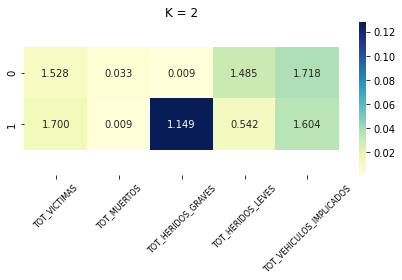

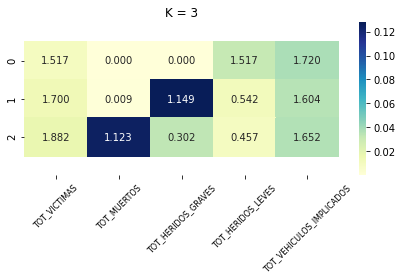

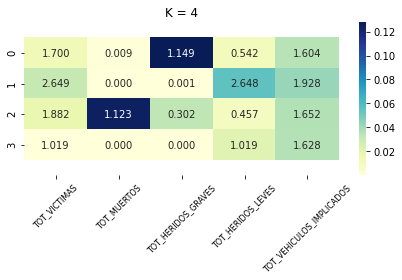

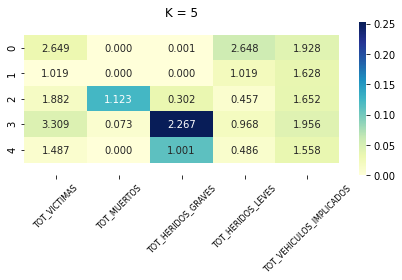

In [ ]:
for k in [2,3,4,5]:
  heatmap = visualize_centroids(centroids[k], data_vias_interurbanas, atributos)   #Devuelve un AvesSubplot
  #heatmap.figure.savefig("heatmap_interurbanas_aglom_k{}.png".format(k))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



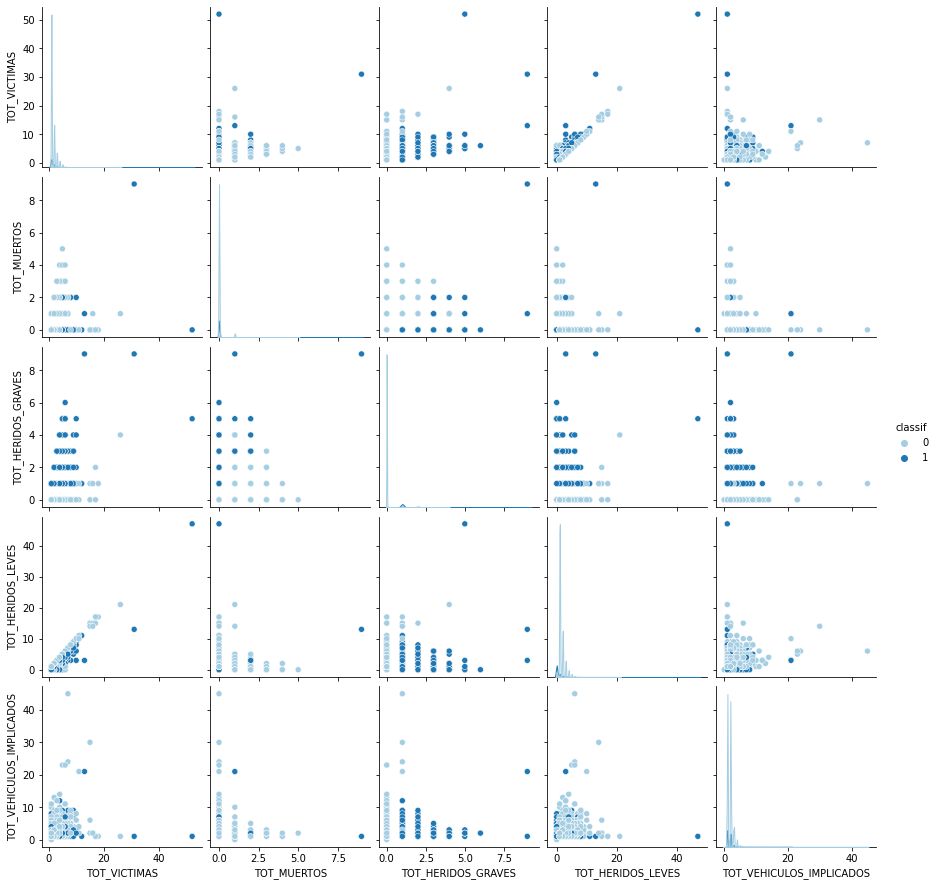

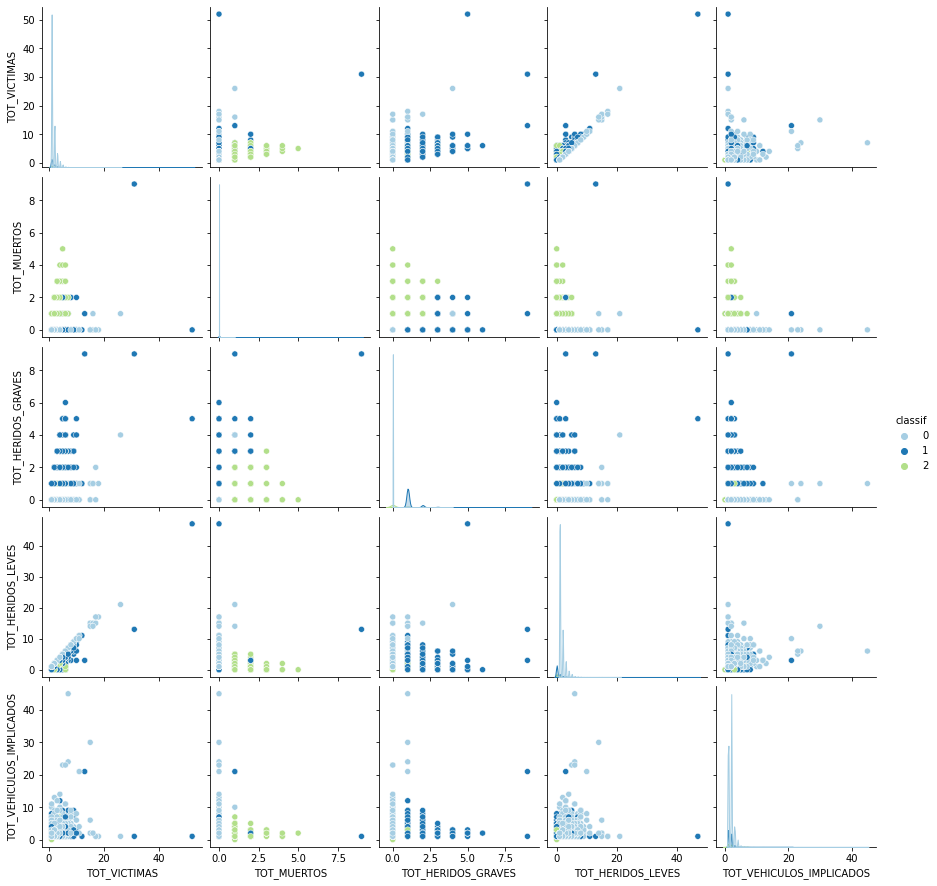

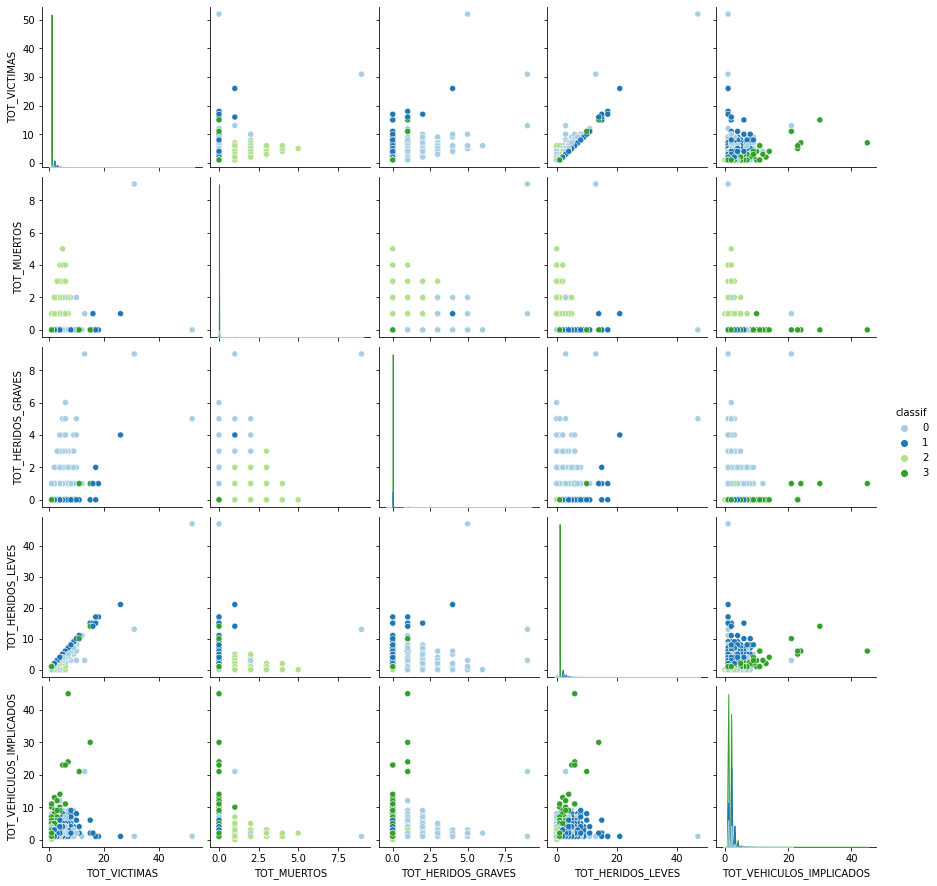

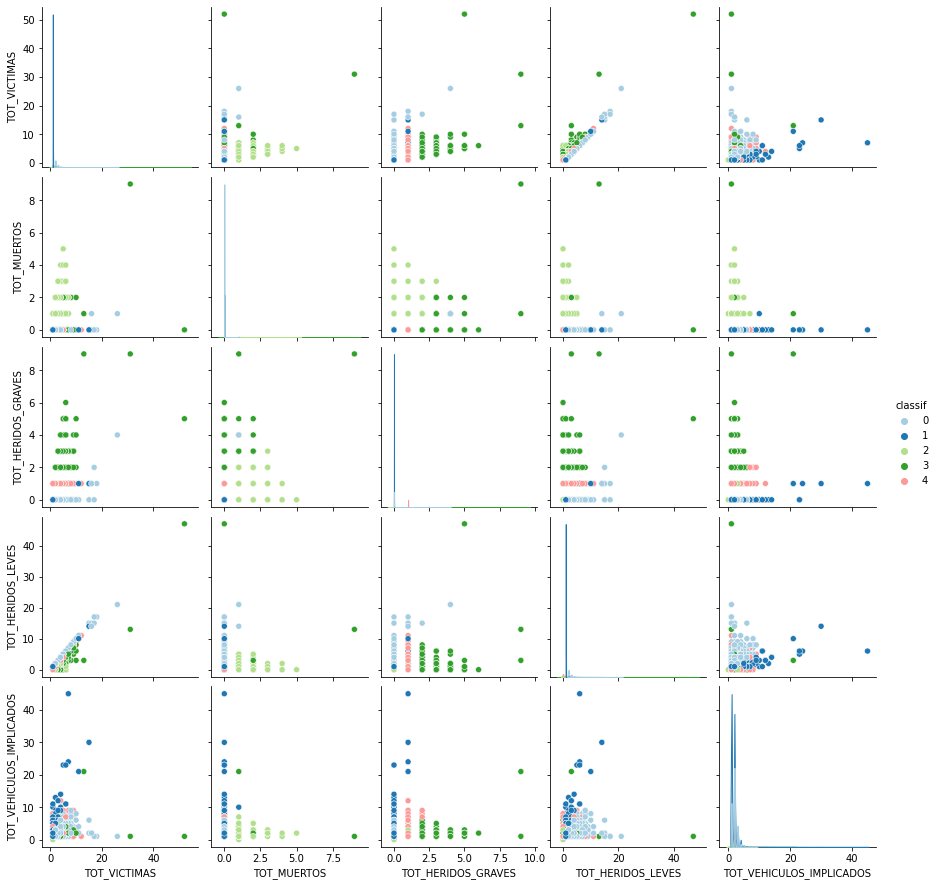

In [ ]:
df = raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"]  #Pairplot necesita un DataFrame y hasta ahora yo almacenaba los datos en ndarrays
for k in [2,3,4,5]:
  pplot = pairplot(df, atributos, labels[k])
  #pplot.savefig("pairplot_interurbanas_aglom_k{}.png".format(k))

## Resultados 

El k-means obtiene resultados ligeramente mejores que los del clustering aglomerativo en ambos casos (siguiendo las medidas Calinski-Harabasz y Silhouette). Recalcularemos estos clusters y analizaremos las agrupaciones obtenidas en cada caso de estudio usando el valor de K que haya dado mejores resultados.

In [91]:
from sklearn.cluster import KMeans

#### Caso 1:

In [92]:
#Recalculamos los clusters obtenidos con kmeans para k=5 
results = KMeans(n_clusters=5, random_state=1, n_init=100).fit(data_vias_urbanas_norm)
labels = results.labels_
centroids = results.cluster_centers_

In [96]:
#Contamos los elementos de cada cluster
Counter(labels)

Counter({0: 15558, 1: 25963, 2: 1185, 3: 9169, 4: 347})

Vemos que hay 2 clusters con una cantidad desproporcionadamente alta de casos, mientras que otros 2 tienen agrupan muy pocas instancias. Esto no tiene por qué ser necesariamente malo desde el punto de vista del análisis, siempre que los grupos pequeños muestren desviaciones suficientemente significativas con respecto a los demás. Entre otras cosas, las medidas realizadas (Calinski-Harabasz y Silhouette) apuntan a que este es el caso.

Recordamos el heatmap del caso 1 para K=5:

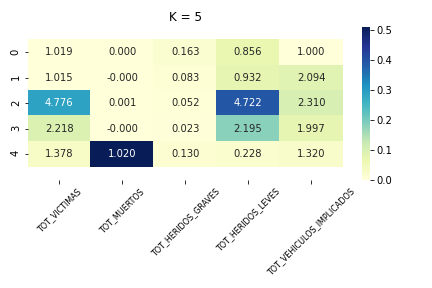

Examinamos cada cluster:

In [ ]:
urbanas_clust = raw_data_vias_urbanas[atributos].copy()
urbanas_clust["Label"] = labels

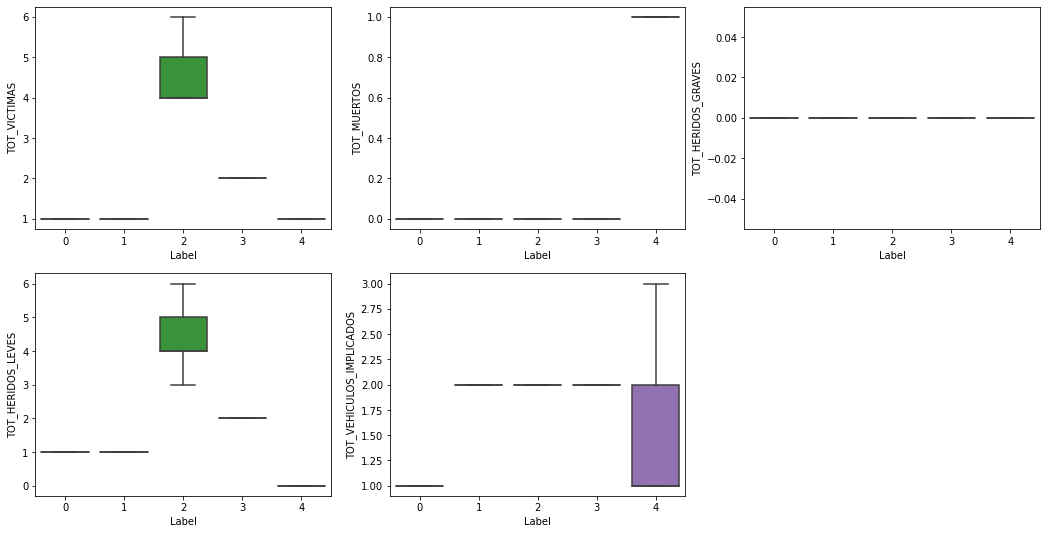

In [ ]:
#Boxplots
fig = plt.figure(figsize=(18,9))
gs = fig.add_gridspec(2, 3)
for k, at in enumerate(atributos):
  ax = fig.add_subplot(gs[k//3, k%3])
  sns.boxplot(x=urbanas_clust["Label"], y=urbanas_clust[at], showfliers=False)

In [ ]:
#urbanas_clust = []
#for k in range(5):
#  urbanas_clust.append(raw_data_vias_urbanas.loc[labels==k])

In [ ]:
#Comparamos las densidades de circulación entre los distintos clusters
#fig = plt.figure(figsize=(18,9))
#gs = fig.add_gridspec(2, 3)
#for k in range(5):
#  ax = fig.add_subplot(gs[k//3, k%3])
#  ax.set_title("Cluster {}".format(k))
#  urbanas_clust[k]["DENSIDAD_CIRCULACION"].hist(grid=False)

#### Caso 2:

In [126]:
from sklearn.cluster import AgglomerativeClustering

In [132]:
results = AgglomerativeClustering(3, memory='clustcache').fit(data_vias_interurbanas_norm)
labels = results.labels_
centroids = calcular_centroides(norm(raw_data.loc[raw_data["ZONA_AGRUPADA"]=="VÍAS INTERURBANAS"][atributos]), results.labels_)

In [ ]:
##Recalculamos los clusters obtenidos con kmeans para k=2
#results = KMeans(n_clusters=2, random_state=1, n_init=100).fit(data_vias_interurbanas_norm)
#labels = results.labels_
#centroids = results.cluster_centers_

In [133]:
#Contamos los elementos de cada cluster
Counter(labels)

Counter({0: 31996, 1: 4327, 2: 974})

Recordamos el heatmap del caso 1 para K=3:

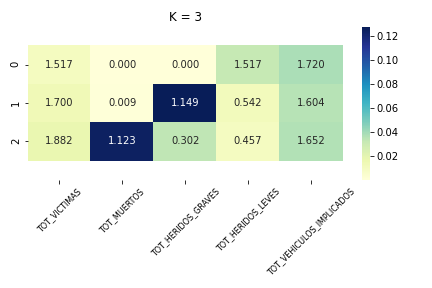

Examinamos cada cluster:

In [134]:
interurbanas_clust = raw_data_vias_interurbanas[atributos].copy()
interurbanas_clust["Label"] = labels

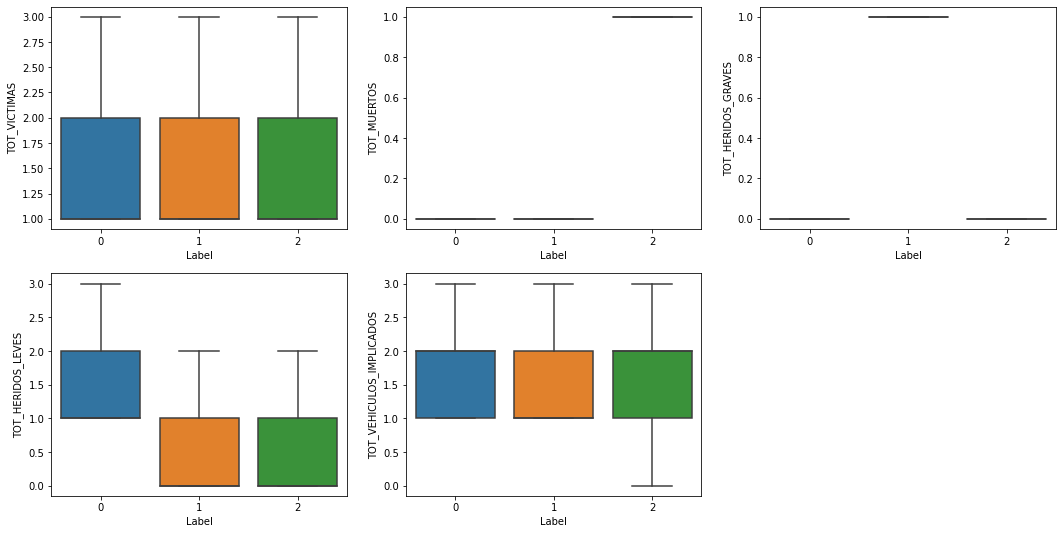

In [135]:
#Boxplots
fig = plt.figure(figsize=(18,9))
gs = fig.add_gridspec(2, 3)
for k, at in enumerate(atributos):
  ax = fig.add_subplot(gs[k//3, k%3])
  sns.boxplot(x=interurbanas_clust["Label"], y=interurbanas_clust[at], showfliers=False)

In [ ]:
#urbanas_clust = []
#for k in range(5):
#  urbanas_clust.append(raw_data_vias_urbanas.loc[labels==k])